<a href="https://colab.research.google.com/github/ArthAgrawal/Vision-Transformer-in-SER/blob/main/RAVDESS_Model_Test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


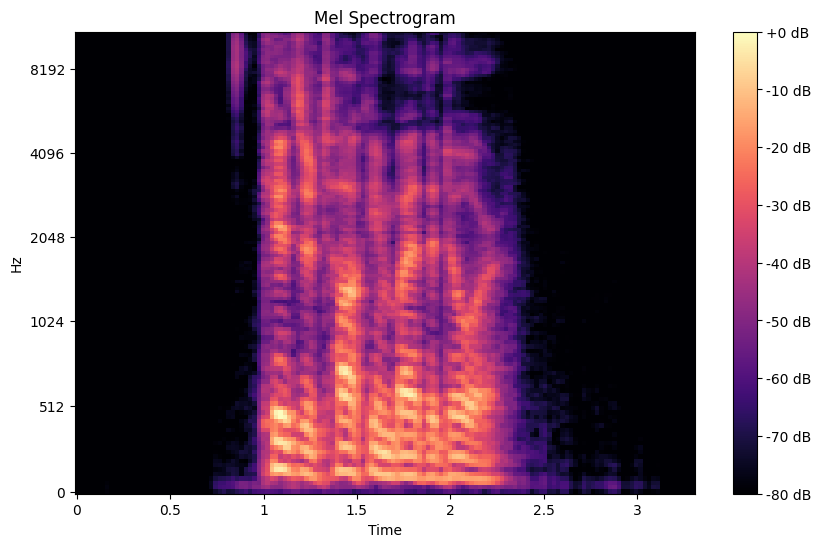

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Function to load audio file and convert to Mel Spectrogram
def audio_to_mel_spectrogram(audio_path, sr=22050, n_mels=128, fmax=8000):
    y, sr = librosa.load(audio_path, sr=sr)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

# Example usage
audio_path = "/content/drive/MyDrive/RAVDESS/Neutral/03-01-01-01-01-01-01.wav"  # Replace with your file path
mel_spectrogram = audio_to_mel_spectrogram(audio_path)

# Plot the Mel Spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Emotion mapping (emotion numbers to names)
emotion_mapping = {
    "01": "Neutral",
    "02": "Calm",
    "03": "Happy",
    "04": "Sad",
    "05": "Angry",
    "06": "Fearful",
    "07": "Disgust",
    "08": "Surprised"
}

def audio_to_mel_spectrogram(audio_path, sr=22050, n_mels=128, fmax=8000, max_len=128):
    y, sr = librosa.load(audio_path, sr=sr)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Padding or truncating to ensure consistent length
    if mel_spectrogram_db.shape[1] > max_len:
        mel_spectrogram_db = mel_spectrogram_db[:, :max_len]
    elif mel_spectrogram_db.shape[1] < max_len:
        pad_width = max_len - mel_spectrogram_db.shape[1]
        mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, pad_width)), mode='constant')

    return mel_spectrogram_db

# Collect spectrograms and labels
X = []
y = []

base_path = "/content/drive/MyDrive/RAVDESS"  # Update with your path

for emotion_folder in os.listdir(base_path):
    emotion_path = os.path.join(base_path, emotion_folder)

    if os.path.isdir(emotion_path):
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                emotion_number = filename.split('-')[2]
                emotion = emotion_mapping.get(emotion_number, None)
                if emotion:
                    audio_path = os.path.join(emotion_path, filename)
                    mel_spectrogram = audio_to_mel_spectrogram(audio_path)
                    X.append(mel_spectrogram)
                    y.append(emotion)

X = np.array(X)
y = np.array(y)

print(f"Dataset size: {X.shape}, Labels size: {y.shape}")


Dataset size: (1440, 128, 128), Labels size: (1440,)


In [ ]:
from sklearn.model_selection import train_test_split

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the split dataset sizes
print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")


Train set size: 1152, Test set size: 288


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add, Embedding, Reshape, Layer
from tensorflow.keras.models import Model

# Define the PositionalEmbedding class as a layer
class PositionalEmbedding(Layer):
    def __init__(self, num_patches, d_model):
        super(PositionalEmbedding, self).__init__()
        self.positional_embeddings = Embedding(input_dim=num_patches, output_dim=d_model)

    def call(self, inputs):
        num_patches = inputs.shape[1]
        positional_indices = tf.range(start=0, limit=num_patches, delta=1)
        positional_embeddings = self.positional_embeddings(positional_indices)
        return inputs + positional_embeddings


def create_vit_model(input_shape, num_classes, patch_size=16, num_heads=4, num_layers=8, d_model=128):
    # Input Layer
    inputs = Input(shape=input_shape, name="input_layer_1")

    # Extract patches using Conv2D with appropriate patch size (no overlap)
    x = Conv2D(filters=d_model, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)

    # Now reshape the output into tokens (patches)
    x = Reshape((-1, d_model))(x)  # Reshape to (batch_size, num_patches, d_model)

    # Number of patches (length of sequence)
    num_patches = x.shape[1]

    # Add positional embeddings using custom PositionalEmbedding layer
    x = PositionalEmbedding(num_patches=num_patches, d_model=d_model)(x)

    # Transformer Encoder Block with Multi-Head Attention and Residual Connection
    for _ in range(num_layers):
        # Multi-Head Attention
        attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        x = Add()([x, attention])  # Add residual connection
        x = LayerNormalization()(x)

        # Feedforward Layer (MLP)
        ff = Dense(d_model, activation='relu')(x)
        ff = Dense(d_model)(ff)
        x = Add()([x, ff])  # Add residual connection
        x = LayerNormalization()(x)
        x = Dropout(0.1)(x)  # Add dropout for regularization

    # After transformer blocks, we need to flatten the sequence of patches
    x = Flatten()(x)

    # Add a Dense layer for final prediction (MLP Head)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs, name="VisionTransformer")

    return model
# Example usage
input_shape = (256, 256, 3)  # Adjust based on your input image size
num_classes = 8  # Number of classes for classification (8 emotions)
model = create_vit_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()



Model: "VisionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 16, 16, 128)    │         98,432 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 256, 128)       │              0 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_2    │ (None, 256, 128)       │         32,768 │ reshape_2[0][0]        │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_52   │ (None, 256, 128)       │        263,808 │ positional_embedding_… │
│ (MultiHeadAttention)      │                        │                │ positional_embedding_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_32 (Add)              │ (None, 256, 128)       │              0 │ positional_embedding_… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_74    │ (None, 256, 128)       │            256 │ add_32[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_124 (Dense)         │ (None, 256, 128)       │         16,512 │ layer_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_125 (Dense)         │ (None, 256, 128)       │         16,512 │ dense_124[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_33 (Add)              │ (None, 256, 128)       │              0 │ layer_normalization_7… │
│                           │                        │                │ dense_125[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_75    │ (None, 256, 128)       │            256 │ add_33[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_70 (Dropout)      │ (None, 256, 128)       │              0 │ layer_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_53   │ (None, 256, 128)       │        263,808 │ dropout_70[0][0],      │
│ (MultiHeadAttention)      │                        │                │ dropout_70[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_34 (Add)              │ (None, 256, 128)       │              0 │ dropout_70[0][0],      │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_76    │ (None, 256, 128)       │            256 │ add_34[0][0]           │
│ (LayerNormalization) 

 Total params: 19,354,376 (73.83 MB)

 Trainable params: 19,354,376 (73.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Encode labels as one-hot vectors
label_mapping = {emotion: idx for idx, emotion in enumerate(emotion_mapping.values())}
y_encoded = np.array([label_mapping[emotion] for emotion in y])

# One-hot encode the labels
y_one_hot = to_categorical(y_encoded, num_classes=8)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Normalize the spectrograms to the range [0, 1]
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

# Check the data shapes
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

# Define the input shape based on the spectrogram size
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])  # (128, 128, 128) in your case
num_classes = 8  # Number of emotions

# Create the ViT model
model = create_vit_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10, batch_size=32)


# Optionally, plot training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


X_train shape: (1152, 128, 128), X_test shape: (288, 128, 128)
y_train shape: (1152, 8), y_test shape: (288, 8)


IndexError: tuple index out of range

Dataset size: (1440, 128, 128), Labels size: (1440,)


Model: "VisionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 4, 4, 256)      │        262,400 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 16, 256)        │              0 │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_4    │ (None, 16, 256)        │          4,096 │ reshape_5[0][0]        │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_69   │ (None, 16, 256)        │      2,103,552 │ positional_embedding_… │
│ (MultiHeadAttention)      │                        │                │ positional_embedding_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_65 (Add)              │ (None, 16, 256)        │              0 │ positional_embedding_… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_107   │ (None, 16, 256)        │            512 │ add_65[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_164 (Dense)         │ (None, 16, 256)        │         65,792 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_165 (Dense)         │ (None, 16, 256)        │         65,792 │ dense_164[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_66 (Add)              │ (None, 16, 256)        │              0 │ layer_normalization_1… │
│                           │                        │                │ dense_165[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_108   │ (None, 16, 256)        │            512 │ add_66[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_112 (Dropout)     │ (None, 16, 256)        │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_70   │ (None, 16, 256)        │      2,103,552 │ dropout_112[0][0],     │
│ (MultiHeadAttention)      │                        │                │ dropout_112[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_67 (Add)              │ (None, 16, 256)        │              0 │ dropout_112[0][0],     │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_109   │ (None, 16, 256)        │            512 │ add_67[0][0]           │
│ (LayerNormalization) 

 Total params: 15,847,816 (60.45 MB)

 Trainable params: 15,847,816 (60.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - accuracy: 0.1270 - loss: 2.4064 - val_accuracy: 0.1285 - val_loss: 2.1921
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1164 - loss: 2.1654 - val_accuracy: 0.1215 - val_loss: 2.1054
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.1179 - loss: 2.1047 - val_accuracy: 0.1285 - val_loss: 2.1004
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1012 - loss: 2.1278 - val_accuracy: 0.1285 - val_loss: 2.1010
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0971 - loss: 2.1074 - val_accuracy: 0.1215 - val_loss: 2.0656
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1172 - loss: 2.0842 - val_accuracy: 0.1215 - val_loss: 2.0712
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1197 - loss: 2.0886 - val_accuracy: 0.1389 - val_loss: 2.0687
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.1506 - loss: 2.0727 - val_accuracy: 0.1285 - 

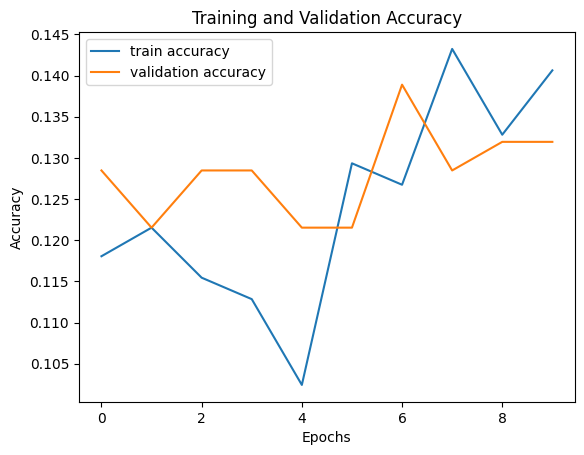

In [ ]:
import librosa
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add, Embedding, Reshape, Layer
from tensorflow.keras.models import Model

# Emotion mapping (emotion numbers to names)
emotion_mapping = {
    "01": "Neutral",
    "02": "Calm",
    "03": "Happy",
    "04": "Sad",
    "05": "Angry",
    "06": "Fearful",
    "07": "Disgust",
    "08": "Surprised"
}

# Function to load audio file and convert to Mel Spectrogram
def audio_to_mel_spectrogram(audio_path, sr=22050, n_mels=128, fmax=8000, max_len=128):
    y, sr = librosa.load(audio_path, sr=sr)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Padding or truncating to ensure consistent length
    if mel_spectrogram_db.shape[1] > max_len:
        mel_spectrogram_db = mel_spectrogram_db[:, :max_len]
    elif mel_spectrogram_db.shape[1] < max_len:
        pad_width = max_len - mel_spectrogram_db.shape[1]
        mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, pad_width)), mode='constant')

    return mel_spectrogram_db

# Collect spectrograms and labels
X = []
y = []

base_path = "/content/drive/MyDrive/RAVDESS"  # Update with your path

for emotion_folder in os.listdir(base_path):
    emotion_path = os.path.join(base_path, emotion_folder)

    if os.path.isdir(emotion_path):
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                emotion_number = filename.split('-')[2]
                emotion = emotion_mapping.get(emotion_number, None)
                if emotion:
                    audio_path = os.path.join(emotion_path, filename)
                    mel_spectrogram = audio_to_mel_spectrogram(audio_path)
                    X.append(mel_spectrogram)
                    y.append(emotion)

X = np.array(X)
y = np.array(y)

print(f"Dataset size: {X.shape}, Labels size: {y.shape}")

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded, num_classes=8)

# Add a channel dimension to the data (grayscale images, so 1 channel)
X = np.expand_dims(X, axis=-1)  # Shape becomes (N, 128, 128, 1)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Define the input shape based on the spectrogram size and number of channels (1 channel for grayscale)
input_shape = (X_train.shape[1], X_train.shape[2], 1)  # (128, 128, 1) for grayscale images
num_classes = 8  # Number of emotions

# Define the PositionalEmbedding class as a layer
class PositionalEmbedding(Layer):
    def __init__(self, num_patches, d_model):
        super(PositionalEmbedding, self).__init__()
        self.positional_embeddings = Embedding(input_dim=num_patches, output_dim=d_model)

    def call(self, inputs):
        num_patches = inputs.shape[1]
        positional_indices = tf.range(start=0, limit=num_patches, delta=1)
        positional_embeddings = self.positional_embeddings(positional_indices)
        return inputs + positional_embeddings


def create_vit_model(input_shape, num_classes, patch_size=32, num_heads=8, num_layers=6, d_model=256, dropout_rate=0.3):
    inputs = Input(shape=input_shape, name="input_layer_1")

    # Extract patches using Conv2D
    x = Conv2D(filters=d_model, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)

    x = Reshape((-1, d_model))(x)  # Reshape to (batch_size, num_patches, d_model)
    num_patches = x.shape[1]

    # Add positional embeddings
    x = PositionalEmbedding(num_patches=num_patches, d_model=d_model)(x)

    # Transformer Encoder Block
    for _ in range(num_layers):
        attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        x = Add()([x, attention])
        x = LayerNormalization()(x)

        ff = Dense(d_model, activation='relu')(x)
        ff = Dense(d_model)(ff)
        x = Add()([x, ff])
        x = LayerNormalization()(x)
        x = Dropout(dropout_rate)(x)

    # Flatten the sequence of patches
    x = Flatten()(x)

    # Dense layers for final prediction
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name="VisionTransformer")

    return model

# Create the modified ViT model
model = create_vit_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    batch_size=32,
                    callbacks=[early_stopping])


# Optionally, plot training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


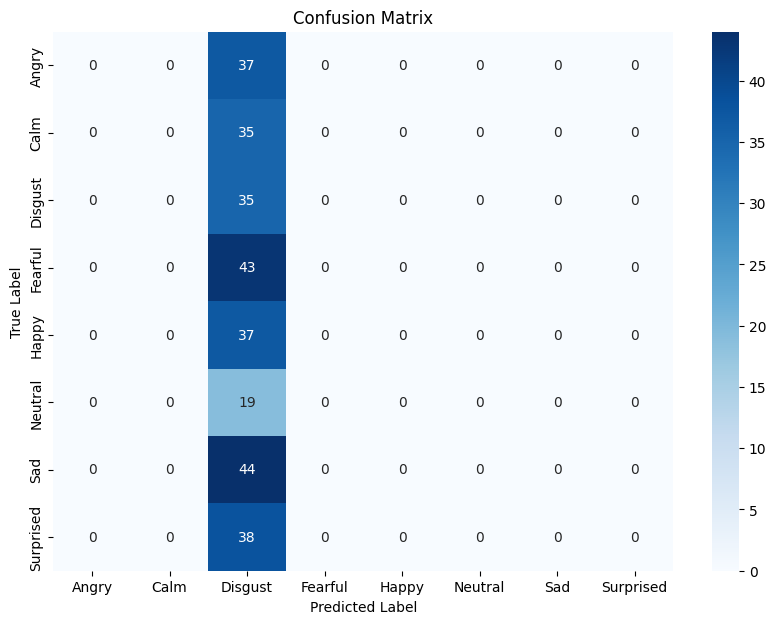

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Dataset size: (1440, 128, 128), Labels size: (1440,)


Model: "SimpleCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_101 (Dropout)                │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_102 (Dropout)                │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_162 (Dense)                    │ (None, 128)                 │     134,217,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_103 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_163 (Dense)                    │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,237,704 (512.08 MB)

 Trainable params: 134,237,704 (512.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.1395 - loss: 1906.7512 - val_accuracy: 0.1215 - val_loss: 2.0784
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.1361 - loss: 2.0679 - val_accuracy: 0.2500 - val_loss: 1.9729
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.4192 - loss: 1.6735 - val_accuracy: 0.3403 - val_loss: 1.8934
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.6702 - loss: 1.0035 - val_accuracy: 0.3715 - val_loss: 2.3268
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8386 - loss: 0.4839 - val_accuracy: 0.3542 - val_loss: 2.3948
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9091 - loss: 0.3154 - val_accuracy: 0.3646 - val_loss: 3.0150
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9616 - loss: 0.1191 - val_accuracy: 0.3507 - val_loss: 3.5629
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9701 - loss: 0.1004 - val_accuracy: 0.3333

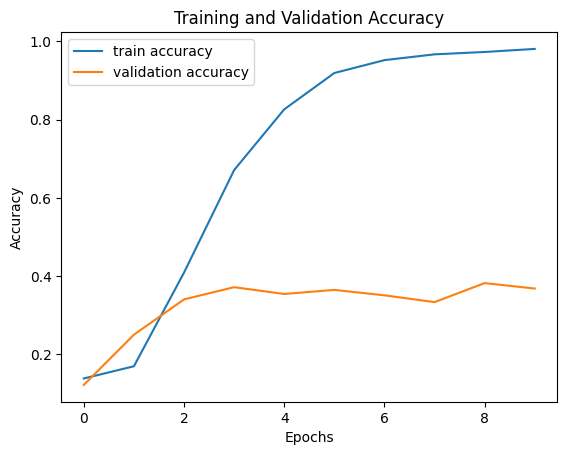

In [ ]:
import librosa
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Emotion mapping (emotion numbers to names)
emotion_mapping = {
    "01": "Neutral",
    "02": "Calm",
    "03": "Happy",
    "04": "Sad",
    "05": "Angry",
    "06": "Fearful",
    "07": "Disgust",
    "08": "Surprised"
}

# Function to load audio file and convert to Mel Spectrogram
def audio_to_mel_spectrogram(audio_path, sr=22050, n_mels=128, fmax=8000, max_len=128):
    y, sr = librosa.load(audio_path, sr=sr)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Padding or truncating to ensure consistent length
    if mel_spectrogram_db.shape[1] > max_len:
        mel_spectrogram_db = mel_spectrogram_db[:, :max_len]
    elif mel_spectrogram_db.shape[1] < max_len:
        pad_width = max_len - mel_spectrogram_db.shape[1]
        mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, pad_width)), mode='constant')

    return mel_spectrogram_db

# Collect spectrograms and labels
X = []
y = []

base_path = "/content/drive/MyDrive/RAVDESS"  # Update with your path

for emotion_folder in os.listdir(base_path):
    emotion_path = os.path.join(base_path, emotion_folder)

    if os.path.isdir(emotion_path):
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                emotion_number = filename.split('-')[2]
                emotion = emotion_mapping.get(emotion_number, None)
                if emotion:
                    audio_path = os.path.join(emotion_path, filename)
                    mel_spectrogram = audio_to_mel_spectrogram(audio_path)
                    X.append(mel_spectrogram)
                    y.append(emotion)

X = np.array(X)
y = np.array(y)

print(f"Dataset size: {X.shape}, Labels size: {y.shape}")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded, num_classes=8)

# Add a channel dimension to the data (grayscale images, so 1 channel)
X = np.expand_dims(X, axis=-1)  # Shape becomes (N, 128, 128, 1)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Define the input shape based on the spectrogram size and number of channels (1 channel for grayscale)
input_shape = (X_train.shape[1], X_train.shape[2], 1)  # (128, 128, 1) for grayscale images
num_classes = 8  # Number of emotions

# Define a Simple CNN Model
def create_simple_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape, name="input_layer")

    # Convolutional Layer 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Dropout(0.2)(x)

    # Convolutional Layer 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)

    # Flatten Layer
    x = Flatten()(x)

    # Dense Layer 1
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create Model
    model = Model(inputs=inputs, outputs=outputs, name="SimpleCNN")
    return model

# Create the simple CNN model
model = create_simple_cnn(input_shape, num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10, batch_size=32)

# Optionally, plot training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


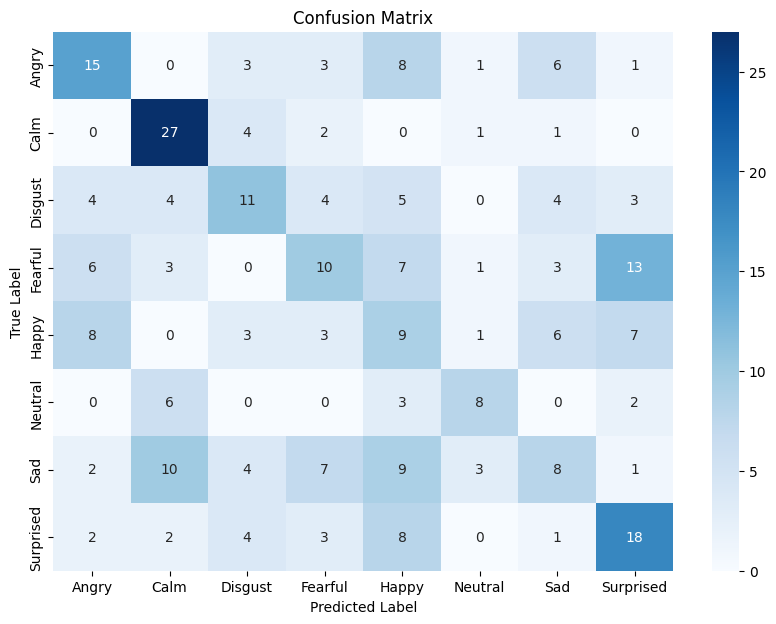

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Reshape, MultiHeadAttention, Add, Dense, LayerNormalization, Dropout, Flatten, Embedding
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define the PositionalEmbedding class as a layer
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_patches, d_model):
        super(PositionalEmbedding, self).__init__()
        self.positional_embeddings = Embedding(input_dim=num_patches, output_dim=d_model)

    def call(self, inputs):
        num_patches = inputs.shape[1]
        positional_indices = tf.range(start=0, limit=num_patches, delta=1)
        positional_embeddings = self.positional_embeddings(positional_indices)
        return inputs + positional_embeddings

# Define Vision Transformer Model
def create_vit_model(input_shape, num_classes, patch_size=16, num_heads=4, num_layers=8, d_model=128, dropout_rate=0.1):
    # Input Layer
    inputs = Input(shape=input_shape, name="input_layer_1")

    # Extract patches using Conv2D with appropriate patch size (no overlap)
    x = Conv2D(filters=d_model, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)

    # Now reshape the output into tokens (patches)
    x = Reshape((-1, d_model))(x)  # Reshape to (batch_size, num_patches, d_model)

    # Number of patches (length of sequence)
    num_patches = x.shape[1]

    # Add positional embeddings using custom PositionalEmbedding layer
    x = PositionalEmbedding(num_patches=num_patches, d_model=d_model)(x)

    # Transformer Encoder Block with Multi-Head Attention and Residual Connection
    for _ in range(num_layers):
        # Multi-Head Attention
        attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        x = Add()([x, attention])  # Add residual connection
        x = LayerNormalization()(x)

        # Feedforward Layer (MLP)
        ff = Dense(d_model * 2, activation='relu')(x)  # Increase width of the MLP
        ff = Dense(d_model)(ff)
        x = Add()([x, ff])  # Add residual connection
        x = LayerNormalization()(x)  # Normalization after addition
        x = Dropout(dropout_rate)(x)  # Add dropout for regularization

    # After transformer blocks, flatten the sequence of patches
    x = Flatten()(x)

    # Add a Dense layer for final prediction (MLP Head)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs, name="VisionTransformer")

    return model

# Compile the model
input_shape = (256, 256, 3)  # Example input shape (256x256 images, 3 channels)
num_classes = 9  # Example number of classes for your task

model = create_vit_model(input_shape, num_classes)

# Compile the model with adjusted learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',  # Use sparse_categorical_crossentropy if labels are integers
              metrics=['accuracy'])

# Print model summary
model.summary()

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Example class weights for handling class imbalance (adjust based on your dataset)
class_weights = {0: 1.0, 1: 10.0, 2: 5.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0}

# Training the model (use your actual dataset for X_train, y_train, X_test, y_test)
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=30,
                    batch_size=32,
                    class_weight=class_weights,
                    callbacks=[early_stopping])

# Plot training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")


Model: "VisionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 16, 16, 128)    │         98,432 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_6 (Reshape)       │ (None, 256, 128)       │              0 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_5    │ (None, 256, 128)       │         32,768 │ reshape_6[0][0]        │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_75   │ (None, 256, 128)       │        263,808 │ positional_embedding_… │
│ (MultiHeadAttention)      │                        │                │ positional_embedding_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_77 (Add)              │ (None, 256, 128)       │              0 │ positional_embedding_… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_119   │ (None, 256, 128)       │            256 │ add_77[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_179 (Dense)         │ (None, 256, 256)       │         33,024 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_180 (Dense)         │ (None, 256, 128)       │         32,896 │ dense_179[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_78 (Add)              │ (None, 256, 128)       │              0 │ layer_normalization_1… │
│                           │                        │                │ dense_180[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_120   │ (None, 256, 128)       │            256 │ add_78[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_124 (Dropout)     │ (None, 256, 128)       │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_76   │ (None, 256, 128)       │        263,808 │ dropout_124[0][0],     │
│ (MultiHeadAttention)      │                        │                │ dropout_124[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_79 (Add)              │ (None, 256, 128)       │              0 │ dropout_124[0][0],     │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_121   │ (None, 256, 128)       │            256 │ add_79[0][0]           │
│ (LayerNormalization) 

 Total params: 19,617,673 (74.84 MB)

 Trainable params: 19,617,673 (74.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


ValueError: Input 0 of layer "VisionTransformer" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(32, 128, 128)